301
** To be processed timesteps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,

True

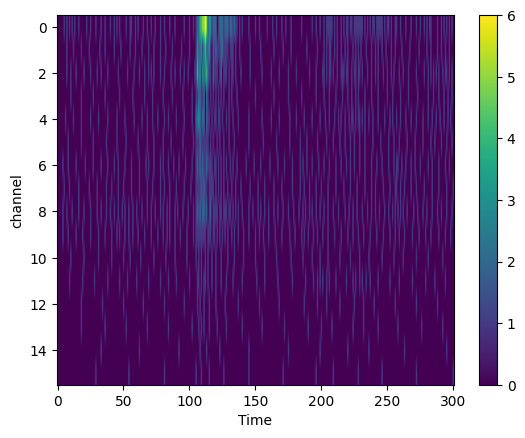

In [1]:
import samna

# Open the device and connect the source and sink nodes so we can communicate with Xylo.
board = samna.device.open_device("XyloAudio3TestBoard")
xylo = board.get_model()
source = samna.graph.source_to(xylo.get_sink_node())

power_monitor = board.get_power_monitor()
sink_pm = samna.graph.sink_from(power_monitor.get_source_node())
stopwatch = board.get_stop_watch()

# Start the stopwatch to enable time-stamped power sampling.
stopwatch.start()

# We are only interested in Readout events, so we make a filter graph to filter only these events.
# Important note: `graph` needs to be kept alive for the filter to work.
graph = samna.graph.EventFilterGraph() 
_, etf, readout_sink = graph.sequential([xylo.get_source_node(), "XyloAudio3OutputEventTypeFilter", samna.graph.JitSink()])
etf.set_desired_type('xyloAudio3::event::Readout')


# Create a basic network with a simple one-to-one mapping of input to output neurons.
xylo_config = samna.xyloAudio3.configuration.XyloConfiguration()
input_count = 3
hidden_count = input_count
output_count = input_count
xylo_config.input.weights = [[127, 0, 0], [0, 127, 0], [0, 0, 127]] # shape(input_count, hidden_count)
xylo_config.hidden.weights = [[0, 0, 0], [0, 0, 0], [0, 0, 0]] # shape(hidden_count, hidden_count)
xylo_config.hidden.neurons = [samna.xyloAudio3.configuration.HiddenNeuron(threshold=127, v_mem_decay=1, i_syn_decay=1)] * hidden_count
xylo_config.readout.weights = [[127, 0, 0], [0, 127, 0], [0, 0, 127]] # shape(hidden_count, output_count)
xylo_config.readout.neurons = [samna.xyloAudio3.configuration.OutputNeuron(threshold=127, v_mem_decay=1, i_syn_decay=1)] * output_count

# Configure Xylo in Accelerated-Time mode and to work with input spike events.
xylo_config.operation_mode = samna.xyloAudio3.OperationMode.AcceleratedTime
xylo_config.input_source = samna.xyloAudio3.InputSource.Saer
xylo_config.debug.event_input_enable = True


# In Accelerated-Time mode we can use automatic state monitoring, by setting the neuron ids we want to monitor.
# Output Vmem and spikes are always activated, so we only monitor the hidden neurons.
xylo_config.debug.monitor_neuron_v_mem = [i for i in range(hidden_count)]
xylo_config.debug.monitor_neuron_spike = [i for i in range(hidden_count)]
# Output Isyn is not available by default, so we add both hidden and output neurons.
xylo_config.debug.monitor_neuron_i_syn = [i for i in range(hidden_count + output_count)]

# Send the configuration to Xylo
xylo.apply_configuration(xylo_config)

# DBG_CTRL1 should be set to 0x0100_0000 (DBG_CTRL1.ALL_RAM_ON = 1), then report the power. 
# source.write([samna.xyloAudio3.event.WriteRegisterValue(address = 0x168, data = 0x0100_0000)])

def read_register(addr):
    events = sink.get_n_events(1, 3000)
    assert(len(events) == 1)
    return events[0].data

def get_current_timestep():
    """Utility function to obtain the current timestep.

    The `Readout` event always contains the current timestep so we could simply save it.
    But in case you forgot what timestep was last processed, you can obtain it as follows.
    """
    source.write([samna.xyloAudio3.event.TriggerReadout()])
    evts = readout_sink.get_n_events(1, timeout=3000)
    assert(len(evts) == 1)
    return evts[0].timestep


def evolve(input):
    """Continue to evolve the model with the given input.
    
    Args:
        input (list[list[int]]): Per timestep a list of integers to specify the number of spikes to send to that `neuron_id`.
                                Max number of spikes per timestep for a neuron is 15. All lists must have the same length.

    Returns:
        readouts (list[Readout]): The `Readout` events for the given timesteps.
    """
    timestep_count = len(input)
    if not timestep_count:
        return []

    power_monitor.start_auto_power_measurement(100) # 100Hz

    start_timestep = get_current_timestep() + 1
    final_timestamp = start_timestep + timestep_count - 1
    print("** To be processed timesteps: ", [timestep for timestep in range(start_timestep, final_timestamp + 1)])
    
    input_events_list = []
    for i, spike_counts in enumerate(input):
        timestep = start_timestep + i
        for neuron_id, count in enumerate(spike_counts):
            spikes = [samna.xyloAudio3.event.Spike(neuron_id=neuron_id, timestep=timestep)] * count
            input_events_list.extend(spikes)

    input_events_list.append(samna.xyloAudio3.event.TriggerProcessing(target_timestep = final_timestamp + 1))
    source.write(input_events_list)

    events = readout_sink.get_n_events(timestep_count, timeout=3000)
    assert(len(events) == timestep_count)

    for idx, ev in enumerate(events):
            print(f"{idx}: {ev}")


    print("waiting for power events")
    events = sink_pm.get_n_events(900, timeout=4000)
    power_monitor.stop_auto_power_measurement()

    counts = [0,0,0]
    sums = [0,0,0]
    avgs = [0,0,0]
    
    for e in events:
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    idx = 0
    for sum, count in zip(sums, counts):
        avgs[idx] = sum/count * 1000
        idx += 1
    
    print(avgs, " in mW")


    return events


# Now we are ready to send spikes to our network and see how the SNN core reacts.
# Start the filter graph, otherwise the events aren't propagated.
graph.start()

import numpy as np
import matplotlib.pyplot as plt
T = 100  #number of time steps
dt = 0.01 #size of time step
Nin = 16 # number of input channels 
p = 0.02 # spiking probability

input_data = np.load("/home/vleite/Downloads/rare_sound_3_second_samples_afe.npy", allow_pickle=True).item()['data'][7]
print(len(input_data))

plt.figure()
plt.imshow(input_data.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

# Send spikes to trigger output neuron 0
readouts = evolve(input_data)

# We have finished processing, so we can stop the graph.
graph.stop()
